In [3]:
#coding: utf-8

import warnings
warnings.simplefilter("ignore")

import os
import sys 
import wave
import time
import librosa
import numpy as np
import seaborn as sns
from utils import *
import matplotlib.pyplot as plt
from StringIO import StringIO

%pylab inline

# sudo pip install librosa
# ubuntu: sudo apt-get install libav-tools
# OSX   : brew install libav OMP_NUM_THREADS=2

Populating the interactive namespace from numpy and matplotlib


# Get the Data

Датасет для контеста помещен вот здесь: https://yadi.sk/d/3jmeVCfSwTKgm (внимание! файл весит 3,5 Гб)


Он распаковывается в папку "musicdata". Все пути в этом ноутбуке будут относительно этой папки: "./musicdata/\*". 

Вы можете изменить базовый путь, как вам удобно.

In [4]:
BP = "./"

# Just a Sound

Для начала попробуем поработать со звуком - послушайте любой трек, постройте график сырых данных и спектрограмму.

In [5]:
import IPython
from IPython import display

def Audio(url):
    return display.HTML("<center><audio controls><source src='{}' type=\"audio/wav\"></audio>".format(url))

In [6]:
sound_file = os.path.join(BP, "audiosamples", "short_206377.wav")
#sound_file = "./short_206377.wav"
y, sr = librosa.load(sound_file)

Audio(url=sound_file)

# Sound as 1D-Signal

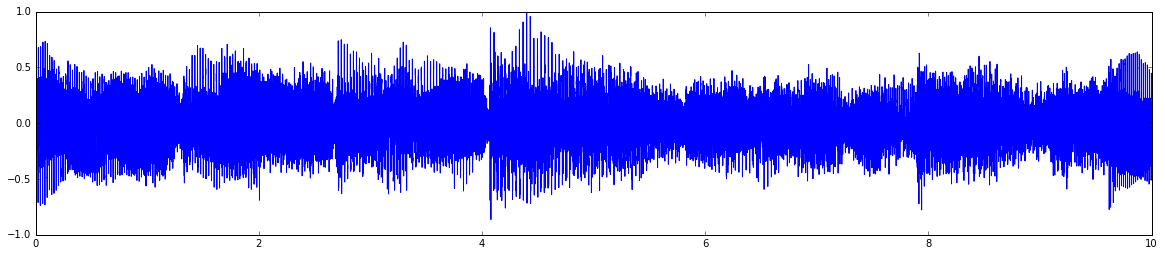

In [7]:
plt.figure(figsize=(20,4))
# 
# Используйте pylab.plot для построения графика, нарисуйте y, sr
x = np.linspace(0, 10, sr*10)
plt.plot(x, y)
pylab.xlim([0, 10])
pylab.show()

# Sound as 2D-Signal

Нашу цель слелать из предыдущего графика картинку - для этого нам нужно оценить частоты в каждый момент времени. Благо за нас это умеет делать librosa, у которой внутри STFFT. Используйте librosa.feature.melspectrogram -- для получения спектрограммы, и librosa.logamplitude для выравнивания диапазонов частот. 

help: https://gist.github.com/mailletf/3484932dd29d62b36092

In [8]:
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
log_S = librosa.logamplitude(S, ref_power=np.max)

Нарисуйте спектрограмму, получилась красивая картинка?

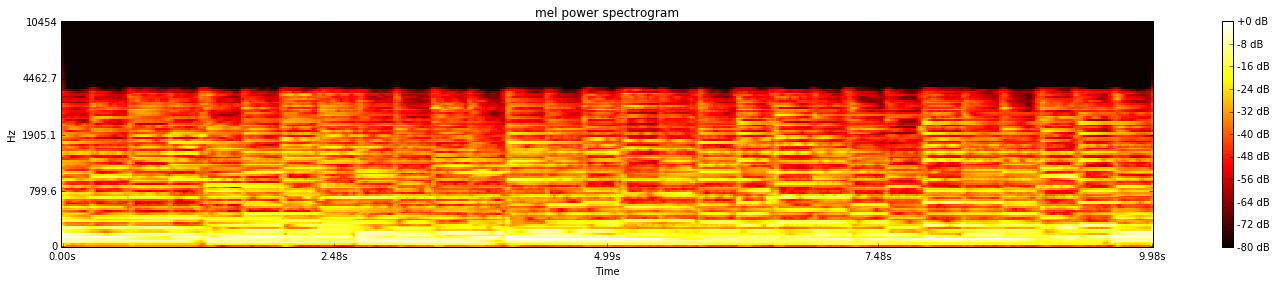

In [9]:
plt.figure(figsize=(20,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap='hot')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

# Prepare the Data

В этой секции мы создадим датасет, прочитав все данные.

In [10]:
import numpy as np
X = np.load(os.path.join(BP, "spectrograms", "spectrograms1.pcl"))

Здесь вы должны получить train genres. Они идут подряд в соответствии с последовательностью треков в файлах с данными. Для содержимого первых шести файлов у вас есть жанры, а для последнего файла, вам их нужно предсказать.

In [11]:
y = []
with open(os.path.join(BP, "train_genres.txt"), "rt") as f_in:
    for line in f_in.readlines():
        y.append(line.split('\n')[0])

In [96]:
y_set = set(y)
num_classes = len(y_set)
classes = list(y_set)
d = {classes[i]: i for i in range(num_classes)}
y_int = np.array([int(d[i]) for i in y])

In [97]:
y_int

array([52,  5, 16, ...,  8, 52,  6])

# Nearest Neighbors genre classification

Let's try to solve similarity task by the nearest neighbour approach.

<img src="./img/nn.png" width="300">

Перемешаем датасет - используйте `np.random.permutation` и индексацию `a[np.random.permutation]`.

In [84]:
perm = np.random.permutation(2000)
X, y_int = X[perm], np.array(y)[perm]
Xreshape = X.reshape(X.shape[0], X.shape[1], X.shape[2])

Разобьем датасет на трейн и валидацию 80/20%.

In [98]:
X_train, X_valid = Xreshape[:1600], Xreshape[1600:]
y_train, y_valid = y_int[:1600], y_int[1600:]

In [99]:
y_valid

array([40,  8,  8,  3, 28, 52,  8,  8,  8, 52, 16,  8,  6, 12, 16, 44, 28,
       28, 22,  2,  8, 52, 17, 12,  8, 47,  8, 37, 33, 12,  8,  5, 36, 44,
       12,  8,  8, 52,  8, 20, 16, 16,  8, 39,  8, 36,  8, 17,  8, 39,  8,
        8, 16,  6,  8, 26,  8, 21,  8,  8, 33,  8,  8, 16,  3,  8, 52,  8,
       52,  8, 52,  5, 52,  8,  8,  6, 28, 12, 28,  8, 13, 47,  8,  8,  8,
       28, 52, 12, 16, 33,  8, 12,  8, 52, 16,  8,  8, 33, 12, 40, 38, 12,
        6, 33, 13,  5,  6,  6, 52,  5, 52,  5, 55, 28, 52, 52,  8, 12, 40,
        8, 26,  8, 39,  8,  8, 12, 28, 17, 44,  6, 28, 52, 22, 12, 35,  8,
       39,  8,  8,  8,  8,  8, 34,  8, 16,  8, 28, 36,  8,  8, 40, 52, 28,
        8,  8, 12,  8,  8,  8,  8, 19,  8, 33,  8, 52, 24, 52, 44,  8,  8,
       31,  5, 39, 12, 52, 48, 40,  8,  8, 24, 28, 52,  6,  5, 52, 44, 50,
        8, 23,  8,  8, 28,  8, 40,  8, 17,  8, 47, 28,  5,  5, 39, 44, 52,
       52, 52,  8, 44, 28, 26,  8,  8,  4, 40,  8,  8, 12, 28, 44, 44, 36,
       36, 23, 52, 16, 33

Попробуем поклассифицировать жанры методом ближайших соседей.

In [86]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(algorithm='brute', metric='cosine')
clf = clf.fit(X_train.reshape((X_train.shape[0], -1)), y_train)
y_val_pred = clf.predict(X_valid.reshape((X_valid.shape[0], -1)))

print accuracy_score(y_valid, y_val_pred)

0.1325


# Fully-Connected Neural Nets

Использовать нейросети - это хорошая идея, давайте начнем с полносвязных сетей.

In [15]:
import theano
import lasagne
import theano.tensor as T
import utils
from utils import train_net

In [122]:
import time
import numpy as np

def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        
        
def train_net(net, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=10, batch_size=5):
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            print inputs.shape, targets.shape
            train_err_batch, train_acc_batch = train_fun(inputs, targets)
            train_err += train_err_batch
            train_acc += train_acc_batch
            train_batches += 1

        # And a full pass over the validation data:
        val_acc = 0
        val_err = 0
        val_batches = 0
        for batch in iterate_minibatches(X_valid, y_valid, batch_size):
            inputs, targets = batch
            val_err_batch, val_acc_batch = test_fun(inputs, targets)
            val_acc  += val_acc_batch
            val_err  += val_err_batch
            val_batches += 1

        # Then we print the results for this epoch:
        ou = "Epoch %3s of %3s train_loss = %.2f val_loss = %.2f train_acc = %.2f val_acc = %.2f"
        print(ou % (epoch + 1, num_epochs, 
                    train_err / train_batches, val_err / val_batches, 
                    train_acc / train_batches * 100, val_acc / val_batches * 100))
    return net

Перемешаем и разобъем датасет.

In [153]:
y_train.dtype, y_valid.dtype

(dtype('int32'), dtype('int32'))

In [102]:
perm = np.random.permutation(len(y_int))
X, y = np.array(X)[perm].astype('float32'), np.array(y_int)[perm]
Xreshape = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

X_train, X_valid = Xreshape[:1600], Xreshape[1600:]
y_train, y_valid = y[:1600], y[1600:]

In [141]:
input_X, target_y = T.tensor4("X", dtype='float32'), T.vector("y", dtype='int32')
nn = lasagne.layers.InputLayer(shape=(None, 1, X.shape[1], X.shape[2]), input_var=input_X) 

nn = lasagne.layers.DenseLayer(nn, num_units=12)
nn = lasagne.layers.DenseLayer(nn, num_units=12)
nn = lasagne.layers.DenseLayer(nn, num_units=12)
#
# Используйте 2-3 больших полносвязных слоя, обучилась ли сеть? если нет то почему?
#

y_predicted = lasagne.layers.get_output(nn)
all_weights = lasagne.layers.get_all_params(nn)

import lasagne.objectives
from lasagne.updates import adam
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = adam(loss, all_weights)

In [142]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)

In [149]:
%time conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs = 10, batch_size=20)

(20L, 1L, 128L, 431L) (20L,)


IndexError: index 24 is out of bounds for axis 1 with size 12
Apply node that caused the error: CrossentropyCategorical1Hot(Elemwise{Composite{(i0 * (i1 + Abs(i1)))}}.0, y)
Toposort index: 26
Inputs types: [TensorType(float64, matrix), TensorType(int32, vector)]
Inputs shapes: [(20L, 12L), (20L,)]
Inputs strides: [(96L, 8L), (4L,)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Sum{acc_dtype=float64}(CrossentropyCategorical1Hot.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "C:\Users\admin\Anaconda2\lib\site-packages\ipykernel\kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\admin\Anaconda2\lib\site-packages\ipykernel\kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\admin\Anaconda2\lib\site-packages\ipykernel\ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\admin\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\admin\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\admin\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-141-00ba6f2aa1c5>", line 16, in <module>
    loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
  File "C:\Users\admin\Anaconda2\lib\site-packages\lasagne\objectives.py", line 146, in categorical_crossentropy
    return theano.tensor.nnet.categorical_crossentropy(predictions, targets)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

# Convolution Neural Nets

Да, вероятно, полносвязные сети не зажгли и kNN не обогнали. Давайте попробуем сверточные, хороший вариант делать одномерные свертки (сразу по всем частотам). Хотя двумерные тоже могут работать. 

Архитектуру можно подсмотреть [тут](http://benanne.github.io/2014/08/05/spotify-cnns.html).

In [31]:
import theano
import lasagne
import theano.tensor as T

from utils import train_net

In [32]:
perm = np.random.permutation(len(y))
X, y = np.array(X)[perm].astype('float32'), np.array(y)[perm]
Xreshape = X.reshape(X.shape[0], X.shape[1], X.shape[2])

X_train, X_valid = Xreshape[:10000], Xreshape[10000:]
y_train, y_valid = y[:10000], y[10000:]

In [ ]:
input_X, target_y = T.tensor3("X", dtype='float64'), T.vector("y", dtype='int32')
nn = lasagne.layers.InputLayer(shape=(None, X.shape[1], X.shape[2]), input_var=input_X) 

nn = ??? Сделайте свою сеть, используя: Conv1DLayer + MaxPool1DLayer + DenseLayer

nn = lasagne.layers.DenseLayer(nn, num_classes, nonlinearity=lasagne.nonlinearities.softmax)

In [ ]:
y_predicted = lasagne.layers.get_output(nn)
all_weights = lasagne.layers.get_all_params(nn)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.adam(loss, all_weights)

In [ ]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)

In [ ]:
Подумайте, какой размер батча нужен и сколько эпох вы можете себе позволить подождать
%time conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=???, batch_size=??)

Валидационная точность должна быть около 0.6 или лучше. 

Давайте нарисуем каждый второй фильтр - можете ли вы проинтерпретировать эти фильтры?

In [ ]:
plt.figure(figsize=(5, 5), dpi=500)
W = lasagne.layers.get_all_params(nn)[0].get_value()
W[::2, :, :] = 0.2
W = np.hstack(W)
pylab.imshow(W, cmap='hot', interpolation="nearest")
pylab.axis('off')
pylab.show()

# Maps of tracks by SVD and tSNE

Хорошая идея посмотреть, как полученое представление отображается с сохранением относительных расстояний на плоскость. Используйте tSNE или PCA.

Help: https://lts2.epfl.ch/blog/perekres/category/visualizing-hidden-structures-in-datasets-using-deep-learning/

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
represent = lasagne.layers.get_output(nn.input_layer)
represent_fun = theano.function([input_X], [represent], allow_input_downcast=True)

In [ ]:
f = lambda x: np.array(represent_fun([x])[0])
track_vectors = map(f, X_train) + map(f, X_valid)
track_vectors = np.concatenate(track_vectors, axis=0)

track_labels = np.array(list(y_train) + list(y_valid))

получите 2d вектора

In [ ]:
X_tsne = ????

нарисуйте получившиеся точки

In [ ]:
plt.figure(figsize=(10,10), dpi=500)
colors = cm.hot(np.linspace(0, 1, len(id2gener)))

for idx, gener in id2gener.items():
    idx_ = np.where(track_labels == idx)
    pylab.scatter(????, ????, c=colors[idx], cmap=cm.hot, label=gener,s=50)

pylab.legend(loc=0, ncol=5)